# Method 2 - Best Ideas Low Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] > qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

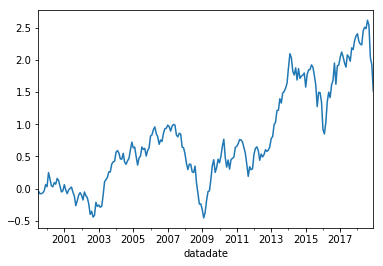

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.060261
2000-12-31   -0.089173
2001-12-31   -0.028722
2002-12-31   -0.229925
2003-12-31    0.973341
2004-12-31    0.208510
2005-12-31   -0.051668
2006-12-31    0.186879
2007-12-31   -0.156502
2008-12-31   -0.534697
2009-12-31    0.913814
2010-12-31    0.125830
2011-12-31   -0.202301
2012-12-31    0.261970
2013-12-31    0.597803
2014-12-31    0.060845
2015-12-31   -0.161787
2016-12-31    0.245358
2017-12-31    0.154883
2018-12-31   -0.253668
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     278.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.08e-86
Time:                        02:10:31   Log-Likelihood:                 455.54
No. Observations:                 234   AIC:                            -901.1
Df Residuals:                     229   BIC:                            -883.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.004      0.316      -0.002       0.007
mktrf          1.1561      0.065     17.755      0.000       1.028       1.284
me             0.6273      0.076      8.281      0.000       0.478       0.776
ia             0.5271      0.115      4.579      0.000       0.300       0.754
roe           -0.8592      0.099     -8.719      0.000      -1.053      -0.665
==============================================================================
Omnibus:                       62.761   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.722
Skew:                           1.179   Prob(JB):                     2.30e-37
Kurtosis:                       6.427   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     134.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.41e-59
Time:                        02:10:32   Log-Likelihood:                 455.54
No. Observations:                 234   AIC:                            -901.1
Df Residuals:                     229   BIC:                            -883.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.925      0.355      -0.003       0.007
mktrf          1.1561      0.063     18.346      0.000       1.033       1.280
me             0.6273      0.066      9.512      0.000       0.498       0.757
ia             0.5271      0.147      3.581      0.000       0.239       0.816
roe           -0.8592      0.174     -4.943      0.000      -1.200      -0.519
==============================================================================
Omnibus:                       62.761   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.722
Skew:                           1.179   Prob(JB):                     2.30e-37
Kurtosis:                       6.427   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     165.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.56e-66
Time:                        02:10:32   Log-Likelihood:                 455.54
No. Observations:                 234   AIC:                            -901.1
Df Residuals:                     229   BIC:                            -883.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      0.961      0.336      -0.002       0.007
mktrf          1.1561      0.055     20.923      0.000       1.048       1.264
me             0.6273      0.069      9.116      0.000       0.492       0.762
ia             0.5271      0.132      3.994      0.000       0.268       0.786
roe           -0.8592      0.186     -4.621      0.000      -1.224      -0.495
==============================================================================
Omnibus:                       62.761   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.722
Skew:                           1.179   Prob(JB):                     2.30e-37
Kurtosis:                       6.427   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     192.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-79
Time:                        02:10:32   Log-Likelihood:                 441.81
No. Observations:                 234   AIC:                            -871.6
Df Residuals:                     228   BIC:                            -850.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.003      0.435      0.664      -0.004       0.006
mktrf          1.2671      0.069     18.274      0.000       1.131       1.404
smb            0.6656      0.091      7.276      0.000       0.485       0.846
hml            0.3546      0.108      3.287      0.001       0.142       0.567
rmw           -0.6757      0.122     -5.540      0.000      -0.916      -0.435
cma            0.2953      0.155      1.905      0.058      -0.010       0.601
==============================================================================
Omnibus:                       69.221   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.022
Skew:                           1.274   Prob(JB):                     3.68e-44
Kurtosis:                       6.745   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     99.62
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.38e-55
Time:                        02:10:32   Log-Likelihood:                 441.81
No. Observations:                 234   AIC:                            -871.6
Df Residuals:                     228   BIC:                            -850.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.003      0.391      0.696      -0.004       0.007
mktrf          1.2671      0.066     19.162      0.000       1.138       1.397
smb            0.6656      0.089      7.487      0.000       0.491       0.840
hml            0.3546      0.174      2.034      0.042       0.013       0.696
rmw           -0.6757      0.212     -3.189      0.001      -1.091      -0.260
cma            0.2953      0.211      1.397      0.163      -0.119       0.710
==============================================================================
Omnibus:                       69.221   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.022
Skew:                           1.274   Prob(JB):                     3.68e-44
Kurtosis:                       6.745   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     114.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.60e-60
Time:                        02:10:32   Log-Likelihood:                 441.81
No. Observations:                 234   AIC:                            -871.6
Df Residuals:                     228   BIC:                            -850.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.003      0.399      0.690      -0.004       0.007
mktrf          1.2671      0.065     19.570      0.000       1.140       1.394
smb            0.6656      0.085      7.791      0.000       0.498       0.833
hml            0.3546      0.146      2.421      0.015       0.068       0.642
rmw           -0.6757      0.228     -2.964      0.003      -1.123      -0.229
cma            0.2953      0.183      1.613      0.107      -0.063       0.654
==============================================================================
Omnibus:                       69.221   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.022
Skew:                           1.274   Prob(JB):                     3.68e-44
Kurtosis:                       6.745   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     233.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.32e-79
Time:                        02:10:32   Log-Likelihood:                 438.84
No. Observations:                 234   AIC:                            -867.7
Df Residuals:                     229   BIC:                            -850.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.060      0.952      -0.005       0.005
mktrf          1.2629      0.064     19.614      0.000       1.136       1.390
smb            0.9746      0.080     12.126      0.000       0.816       1.133
hml            0.3499      0.080      4.383      0.000       0.193       0.507
umd           -0.3005      0.052     -5.737      0.000      -0.404      -0.197
==============================================================================
Omnibus:                       81.098   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.329
Skew:                           1.391   Prob(JB):                     3.03e-67
Kurtosis:                       7.866   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     172.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.90e-68
Time:                        02:10:32   Log-Likelihood:                 438.84
No. Observations:                 234   AIC:                            -867.7
Df Residuals:                     229   BIC:                            -850.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.063      0.949      -0.005       0.005
mktrf          1.2629      0.062     20.305      0.000       1.141       1.385
smb            0.9746      0.074     13.162      0.000       0.829       1.120
hml            0.3499      0.133      2.637      0.008       0.090       0.610
umd           -0.3005      0.096     -3.143      0.002      -0.488      -0.113
==============================================================================
Omnibus:                       81.098   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.329
Skew:                           1.391   Prob(JB):                     3.03e-67
Kurtosis:                       7.866   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     205.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.35e-74
Time:                        02:10:32   Log-Likelihood:                 438.84
No. Observations:                 234   AIC:                            -867.7
Df Residuals:                     229   BIC:                            -850.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.068      0.946      -0.004       0.005
mktrf          1.2629      0.057     22.003      0.000       1.150       1.375
smb            0.9746      0.068     14.419      0.000       0.842       1.107
hml            0.3499      0.127      2.748      0.006       0.100       0.600
umd           -0.3005      0.093     -3.247      0.001      -0.482      -0.119
==============================================================================
Omnibus:                       81.098   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.329
Skew:                           1.391   Prob(JB):                     3.03e-67
Kurtosis:                       7.866   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     138.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.44e-43
Time:                        02:10:32   Log-Likelihood:                 220.60
No. Observations:                 120   AIC:                            -431.2
Df Residuals:                     115   BIC:                            -417.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.072      0.286      -0.003       0.011
mktrf          1.1720      0.101     11.564      0.000       0.971       1.373
me             0.5703      0.100      5.697      0.000       0.372       0.769
ia             0.5985      0.157      3.818      0.000       0.288       0.909
roe           -0.7760      0.139     -5.593      0.000      -1.051      -0.501
==============================================================================
Omnibus:                       34.161   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.693
Skew:                           1.129   Prob(JB):                     2.22e-17
Kurtosis:                       6.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     69.73
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.50e-30
Time:                        02:10:32   Log-Likelihood:                 220.60
No. Observations:                 120   AIC:                            -431.2
Df Residuals:                     115   BIC:                            -417.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.011      0.312      -0.004       0.012
mktrf          1.1720      0.086     13.705      0.000       1.004       1.340
me             0.5703      0.077      7.360      0.000       0.418       0.722
ia             0.5985      0.181      3.308      0.001       0.244       0.953
roe           -0.7760      0.210     -3.692      0.000      -1.188      -0.364
==============================================================================
Omnibus:                       34.161   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.693
Skew:                           1.129   Prob(JB):                     2.22e-17
Kurtosis:                       6.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     74.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.79e-31
Time:                        02:10:32   Log-Likelihood:                 220.60
No. Observations:                 120   AIC:                            -431.2
Df Residuals:                     115   BIC:                            -417.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.060      0.289      -0.003       0.011
mktrf          1.1720      0.081     14.541      0.000       1.014       1.330
me             0.5703      0.084      6.799      0.000       0.406       0.735
ia             0.5985      0.145      4.129      0.000       0.314       0.883
roe           -0.7760      0.225     -3.445      0.001      -1.218      -0.334
==============================================================================
Omnibus:                       34.161   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.693
Skew:                           1.129   Prob(JB):                     2.22e-17
Kurtosis:                       6.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     96.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.54e-39
Time:                        02:10:32   Log-Likelihood:                 214.33
No. Observations:                 120   AIC:                            -416.7
Df Residuals:                     114   BIC:                            -399.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.004      0.930      0.354      -0.004       0.012
mktrf          1.3552      0.113     11.983      0.000       1.131       1.579
smb            0.6230      0.128      4.864      0.000       0.369       0.877
hml            0.2750      0.157      1.752      0.082      -0.036       0.586
rmw           -0.5627      0.185     -3.040      0.003      -0.929      -0.196
cma            0.4526      0.203      2.232      0.028       0.051       0.854
==============================================================================
Omnibus:                       39.176   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.975
Skew:                           1.314   Prob(JB):                     1.30e-19
Kurtosis:                       6.239   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     53.02
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.56e-28
Time:                        02:10:32   Log-Likelihood:                 214.33
No. Observations:                 120   AIC:                            -416.7
Df Residuals:                     114   BIC:                            -399.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.005      0.808      0.419      -0.005       0.013
mktrf          1.3552      0.097     14.036      0.000       1.166       1.544
smb            0.6230      0.121      5.170      0.000       0.387       0.859
hml            0.2750      0.217      1.268      0.205      -0.150       0.700
rmw           -0.5627      0.277     -2.033      0.042      -1.105      -0.020
cma            0.4526      0.245      1.851      0.064      -0.027       0.932
==============================================================================
Omnibus:                       39.176   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.975
Skew:                           1.314   Prob(JB):                     1.30e-19
Kurtosis:                       6.239   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     68.11
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-32
Time:                        02:10:32   Log-Likelihood:                 214.33
No. Observations:                 120   AIC:                            -416.7
Df Residuals:                     114   BIC:                            -399.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.005      0.789      0.430      -0.006       0.013
mktrf          1.3552      0.095     14.246      0.000       1.169       1.542
smb            0.6230      0.119      5.232      0.000       0.390       0.856
hml            0.2750      0.204      1.347      0.178      -0.125       0.675
rmw           -0.5627      0.308     -1.829      0.067      -1.166       0.040
cma            0.4526      0.208      2.180      0.029       0.046       0.860
==============================================================================
Omnibus:                       39.176   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.975
Skew:                           1.314   Prob(JB):                     1.30e-19
Kurtosis:                       6.239   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     121.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.44e-40
Time:                        02:10:32   Log-Likelihood:                 214.20
No. Observations:                 120   AIC:                            -418.4
Df Residuals:                     115   BIC:                            -404.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.004      0.660      0.510      -0.005       0.010
mktrf          1.2765      0.094     13.554      0.000       1.090       1.463
smb            0.9490      0.107      8.851      0.000       0.737       1.161
hml            0.3484      0.107      3.244      0.002       0.136       0.561
umd           -0.2943      0.066     -4.444      0.000      -0.425      -0.163
==============================================================================
Omnibus:                       49.303   Durbin-Watson:                   2.339
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.019
Skew:                           1.463   Prob(JB):                     2.42e-36
Kurtosis:                       7.923   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     91.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.43e-35
Time:                        02:10:32   Log-Likelihood:                 214.20
No. Observations:                 120   AIC:                            -418.4
Df Residuals:                     115   BIC:                            -404.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.004      0.680      0.497      -0.005       0.010
mktrf          1.2765      0.085     15.083      0.000       1.111       1.442
smb            0.9490      0.108      8.828      0.000       0.738       1.160
hml            0.3484      0.162      2.148      0.032       0.031       0.666
umd           -0.2943      0.104     -2.821      0.005      -0.499      -0.090
==============================================================================
Omnibus:                       49.303   Durbin-Watson:                   2.339
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.019
Skew:                           1.463   Prob(JB):                     2.42e-36
Kurtosis:                       7.923   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     101.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.14e-37
Time:                        02:10:32   Log-Likelihood:                 214.20
No. Observations:                 120   AIC:                            -418.4
Df Residuals:                     115   BIC:                            -404.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.004      0.707      0.479      -0.005       0.010
mktrf          1.2765      0.083     15.441      0.000       1.114       1.439
smb            0.9490      0.106      8.917      0.000       0.740       1.158
hml            0.3484      0.164      2.122      0.034       0.027       0.670
umd           -0.2943      0.101     -2.908      0.004      -0.493      -0.096
==============================================================================
Omnibus:                       49.303   Durbin-Watson:                   2.339
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.019
Skew:                           1.463   Prob(JB):                     2.42e-36
Kurtosis:                       7.923   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     170.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.44e-46
Time:                        02:10:32   Log-Likelihood:                 250.39
No. Observations:                 114   AIC:                            -490.8
Df Residuals:                     109   BIC:                            -477.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.538      0.592      -0.004       0.007
mktrf          1.1553      0.081     14.280      0.000       0.995       1.316
me             0.7271      0.125      5.821      0.000       0.480       0.975
ia             0.0839      0.173      0.484      0.629      -0.260       0.427
roe           -1.3248      0.152     -8.702      0.000      -1.627      -1.023
==============================================================================
Omnibus:                       26.871   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.785
Skew:                           1.029   Prob(JB):                     6.93e-11
Kurtosis:                       5.369   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     393.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.12e-64
Time:                        02:10:32   Log-Likelihood:                 250.39
No. Observations:                 114   AIC:                            -490.8
Df Residuals:                     109   BIC:                            -477.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.553      0.581      -0.004       0.007
mktrf          1.1553      0.076     15.168      0.000       1.006       1.305
me             0.7271      0.088      8.217      0.000       0.554       0.901
ia             0.0839      0.169      0.497      0.619      -0.247       0.415
roe           -1.3248      0.202     -6.574      0.000      -1.720      -0.930
==============================================================================
Omnibus:                       26.871   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.785
Skew:                           1.029   Prob(JB):                     6.93e-11
Kurtosis:                       5.369   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     734.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.16e-78
Time:                        02:10:32   Log-Likelihood:                 250.39
No. Observations:                 114   AIC:                            -490.8
Df Residuals:                     109   BIC:                            -477.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.573      0.566      -0.004       0.007
mktrf          1.1553      0.066     17.508      0.000       1.026       1.285
me             0.7271      0.091      8.018      0.000       0.549       0.905
ia             0.0839      0.165      0.510      0.610      -0.239       0.406
roe           -1.3248      0.178     -7.462      0.000      -1.673      -0.977
==============================================================================
Omnibus:                       26.871   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.785
Skew:                           1.029   Prob(JB):                     6.93e-11
Kurtosis:                       5.369   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     109.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.38e-40
Time:                        02:10:32   Log-Likelihood:                 239.99
No. Observations:                 114   AIC:                            -468.0
Df Residuals:                     108   BIC:                            -451.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.323      0.748      -0.007       0.005
mktrf          1.2185      0.085     14.349      0.000       1.050       1.387
smb            0.7225      0.138      5.241      0.000       0.449       0.996
hml            0.2387      0.176      1.357      0.177      -0.110       0.587
rmw           -1.2582      0.215     -5.844      0.000      -1.685      -0.831
cma           -0.0011      0.273     -0.004      0.997      -0.543       0.541
==============================================================================
Omnibus:                       12.140   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.459
Skew:                           0.621   Prob(JB):                     0.000725
Kurtosis:                       4.226   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     83.33
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.88e-35
Time:                        02:10:32   Log-Likelihood:                 239.99
No. Observations:                 114   AIC:                            -468.0
Df Residuals:                     108   BIC:                            -451.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.323      0.747      -0.007       0.005
mktrf          1.2185      0.097     12.608      0.000       1.029       1.408
smb            0.7225      0.093      7.745      0.000       0.540       0.905
hml            0.2387      0.249      0.960      0.337      -0.249       0.726
rmw           -1.2582      0.341     -3.689      0.000      -1.927      -0.590
cma           -0.0011      0.228     -0.005      0.996      -0.448       0.446
==============================================================================
Omnibus:                       12.140   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.459
Skew:                           0.621   Prob(JB):                     0.000725
Kurtosis:                       4.226   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     82.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.59e-35
Time:                        02:10:32   Log-Likelihood:                 239.99
No. Observations:                 114   AIC:                            -468.0
Df Residuals:                     108   BIC:                            -451.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.407      0.684      -0.006       0.004
mktrf          1.2185      0.097     12.533      0.000       1.028       1.409
smb            0.7225      0.092      7.865      0.000       0.542       0.903
hml            0.2387      0.274      0.872      0.383      -0.298       0.775
rmw           -1.2582      0.333     -3.777      0.000      -1.911      -0.605
cma           -0.0011      0.231     -0.005      0.996      -0.454       0.452
==============================================================================
Omnibus:                       12.140   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.459
Skew:                           0.621   Prob(JB):                     0.000725
Kurtosis:                       4.226   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     106.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-36
Time:                        02:10:32   Log-Likelihood:                 227.89
No. Observations:                 114   AIC:                            -445.8
Df Residuals:                     109   BIC:                            -432.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.702      0.484      -0.009       0.004
mktrf          1.2707      0.093     13.605      0.000       1.086       1.456
smb            1.0167      0.146      6.981      0.000       0.728       1.305
hml            0.2958      0.150      1.972      0.051      -0.002       0.593
umd           -0.3197      0.113     -2.826      0.006      -0.544      -0.095
==============================================================================
Omnibus:                       33.900   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.780
Skew:                           1.138   Prob(JB):                     4.74e-18
Kurtosis:                       6.408   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     120.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.32e-39
Time:                        02:10:32   Log-Likelihood:                 227.89
No. Observations:                 114   AIC:                            -445.8
Df Residuals:                     109   BIC:                            -432.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.842      0.400      -0.008       0.003
mktrf          1.2707      0.099     12.792      0.000       1.076       1.465
smb            1.0167      0.126      8.082      0.000       0.770       1.263
hml            0.2958      0.251      1.179      0.239      -0.196       0.788
umd           -0.3197      0.100     -3.200      0.001      -0.516      -0.124
==============================================================================
Omnibus:                       33.900   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.780
Skew:                           1.138   Prob(JB):                     4.74e-18
Kurtosis:                       6.408   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     132.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.59e-41
Time:                        02:10:32   Log-Likelihood:                 227.89
No. Observations:                 114   AIC:                            -445.8
Df Residuals:                     109   BIC:                            -432.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.920      0.357      -0.007       0.003
mktrf          1.2707      0.096     13.186      0.000       1.082       1.460
smb            1.0167      0.107      9.500      0.000       0.807       1.226
hml            0.2958      0.275      1.076      0.282      -0.243       0.835
umd           -0.3197      0.084     -3.824      0.000      -0.484      -0.156
==============================================================================
Omnibus:                       33.900   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.780
Skew:                           1.138   Prob(JB):                     4.74e-18
Kurtosis:                       6.408   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""